<a href="https://colab.research.google.com/github/AdvaitaMenon/Stock-Trading-Strategy-Backtester/blob/main/Stock_Trading_Strategy_Backtester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [70]:
def fetch_data(ticker, start_date, end_date):
    """
    Fetch historical stock data using yfinance.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Example usage to fetch Apple stock data from 2010 to 2023
ticker = 'AAPL'
start_date = '2013-01-01'
end_date = '2023-01-01'
data = fetch_data(ticker, start_date, end_date)

# Display the first few rows of the data
data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.705700,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.494835,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.035378,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,15.941055,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,15.983960,458707200


In [71]:
def train_test_split(data, train_size=0.8):
    """
    Splits the data into a training set and a testing set.
    """
    split_idx = int(len(data) * train_size)
    train_data = data[:split_idx].copy()
    test_data = data[split_idx:].copy()

    return train_data, test_data

# Split the data into train and test sets
train_data, test_data = train_test_split(data)

# Display the sizes of the training and testing datasets
print(f"Training data: {len(train_data)} rows")
print(f"Testing data: {len(test_data)} rows")


Training data: 2014 rows
Testing data: 504 rows


In [72]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    data['RSI'] = rsi
    return data

def rsi_strategy(data, rsi_upper=70, rsi_lower=30):
    data = calculate_rsi(data)
    data['Signal'] = 0
    data.loc[data['RSI'] < rsi_lower, 'Signal'] = 1  # Buy signal
    data.loc[data['RSI'] > rsi_upper, 'Signal'] = -1  # Sell signal

    return data


In [73]:
def moving_average_strategy(data, short_window=50, long_window=200):
    data['SMA50'] = data['Close'].rolling(window=short_window).mean()
    data['SMA200'] = data['Close'].rolling(window=long_window).mean()

    data['Signal'] = 0
    data.loc[data['SMA50'] > data['SMA200'], 'Signal'] = 1  # Buy signal
    data.loc[data['SMA50'] < data['SMA200'], 'Signal'] = -1  # Sell signal

    return data


In [74]:
def breakout_strategy(data, window=20):
    data['Rolling Max'] = data['Close'].rolling(window=window).max()
    data['Rolling Min'] = data['Close'].rolling(window=window).min()

    # Buy when price breaks above rolling max, sell when price breaks below rolling min
    data['Signal'] = 0
    data.loc[data['Close'] > data['Rolling Max'].shift(1), 'Signal'] = 1  # Buy
    data.loc[data['Close'] < data['Rolling Min'].shift(1), 'Signal'] = -1  # Sell

    return data


In [75]:
def backtest_strategy(data):
    """
    Backtests a strategy using signal data.
    """
    data['Position'] = data['Signal'].shift()  # Shift the signal to simulate real trading
    data['Daily Return'] = data['Position'] * data['Close'].pct_change()
    data['Cumulative Return'] = (1 + data['Daily Return']).cumprod()
    data['Cumulative Return'].fillna(1.0, inplace=True)  # Fill missing values with the initial investment value (1.0)

    return data


In [76]:
def momentum_strategy(data, window=12):
    data['Momentum'] = data['Close'].pct_change(periods=window)

    # Buy if momentum is positive, sell if momentum is negative
    data['Signal'] = 0
    data.loc[data['Momentum'] > 0, 'Signal'] = 1  # Buy
    data.loc[data['Momentum'] < 0, 'Signal'] = -1  # Sell

    return data


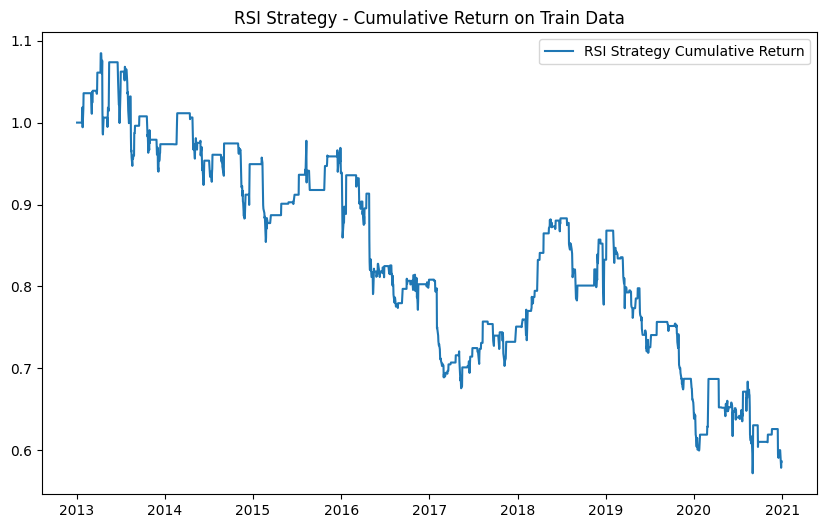

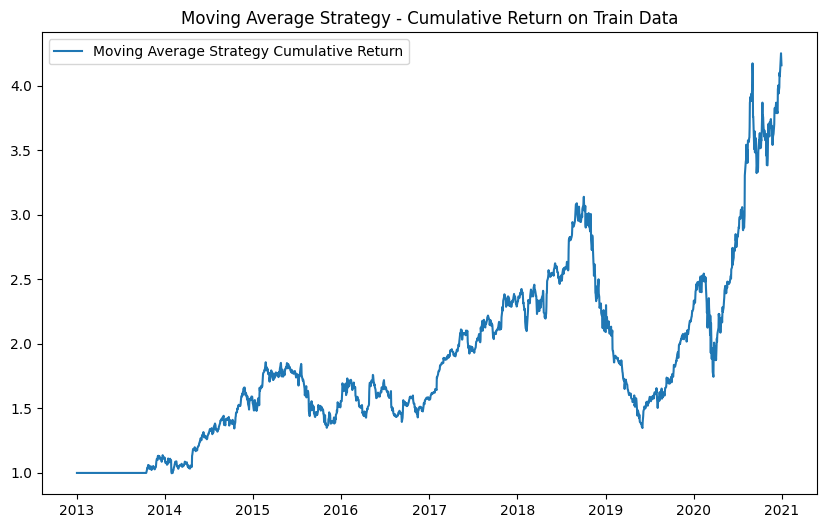

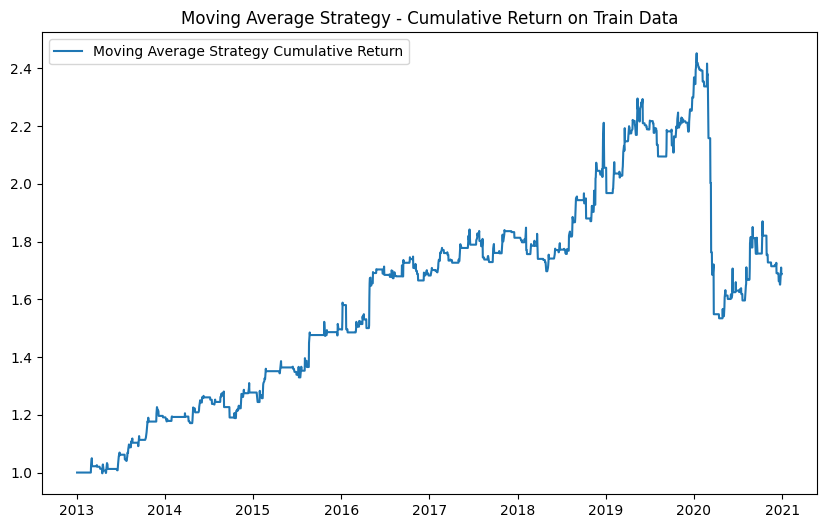

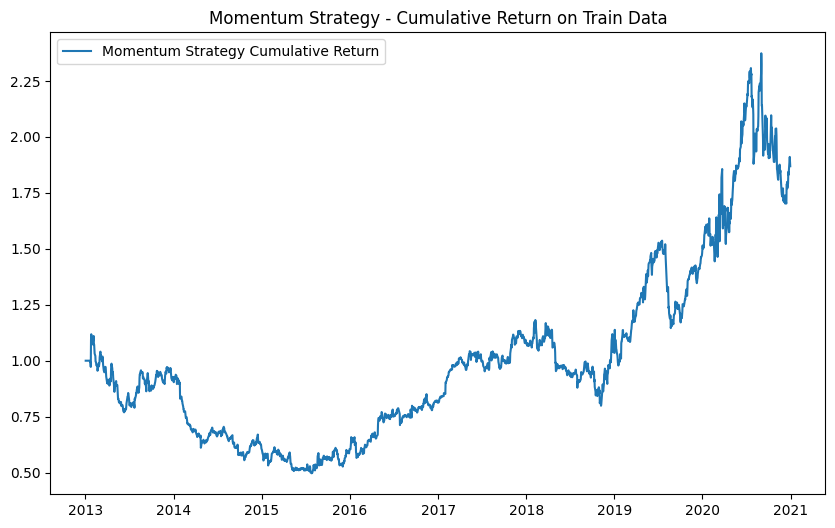

In [77]:
# Apply RSI and Moving Average strategies to the training data
train_data_rsi = rsi_strategy(train_data.copy())
train_data_ma = moving_average_strategy(train_data.copy())
train_data_bs = breakout_strategy(train_data.copy())
train_data_ms = momentum_strategy(train_data.copy())

# Backtest the strategies on the training data
train_data_rsi = backtest_strategy(train_data_rsi)
train_data_ma = backtest_strategy(train_data_ma)
train_data_bs = backtest_strategy(train_data_bs)
train_data_ms = backtest_strategy(train_data_ms)

# Visualize the cumulative return of both strategies on the training data
def plot_cumulative_return(data, strategy_name):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Cumulative Return'], label=f'{strategy_name} Cumulative Return')
    plt.title(f'{strategy_name} - Cumulative Return on Train Data')
    plt.legend()
    plt.show()

plot_cumulative_return(train_data_rsi, 'RSI Strategy')
plot_cumulative_return(train_data_ma, 'Moving Average Strategy')
plot_cumulative_return(train_data_bs, 'Moving Average Strategy')
plot_cumulative_return(train_data_ms, 'Momentum Strategy')

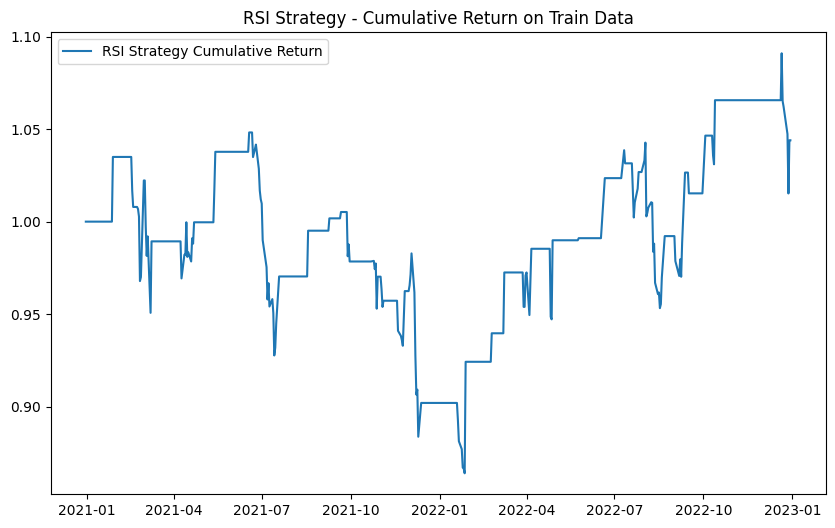

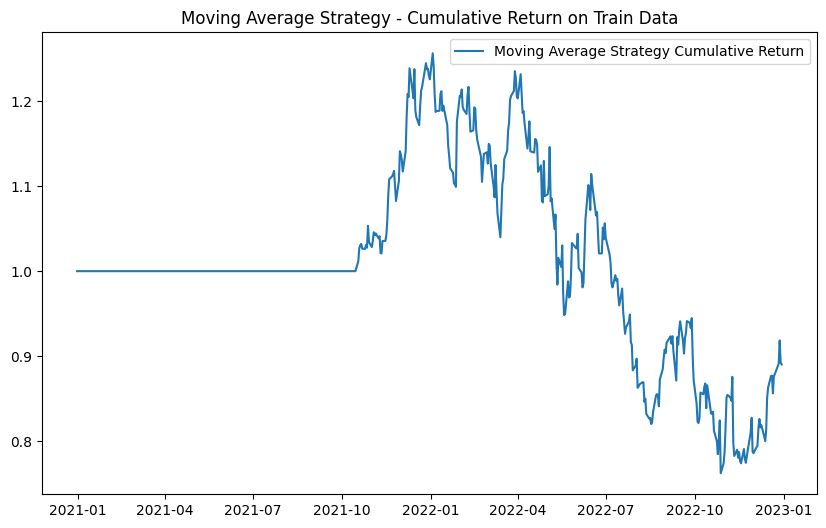

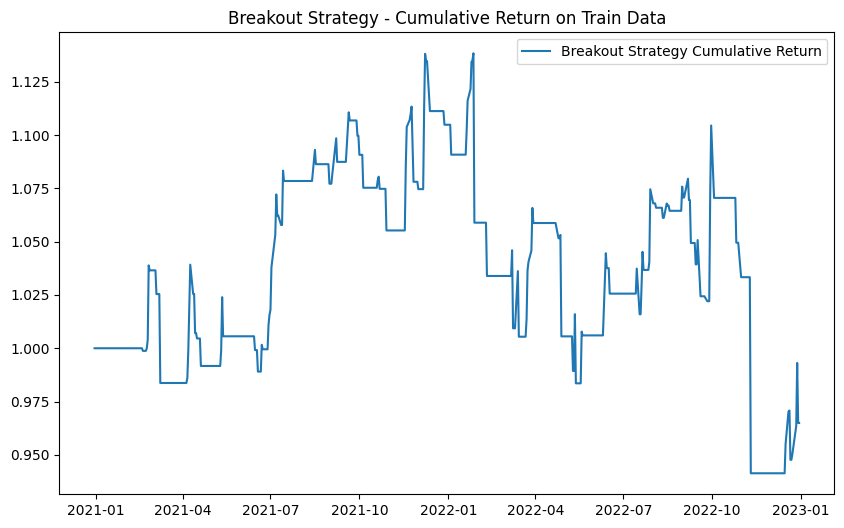

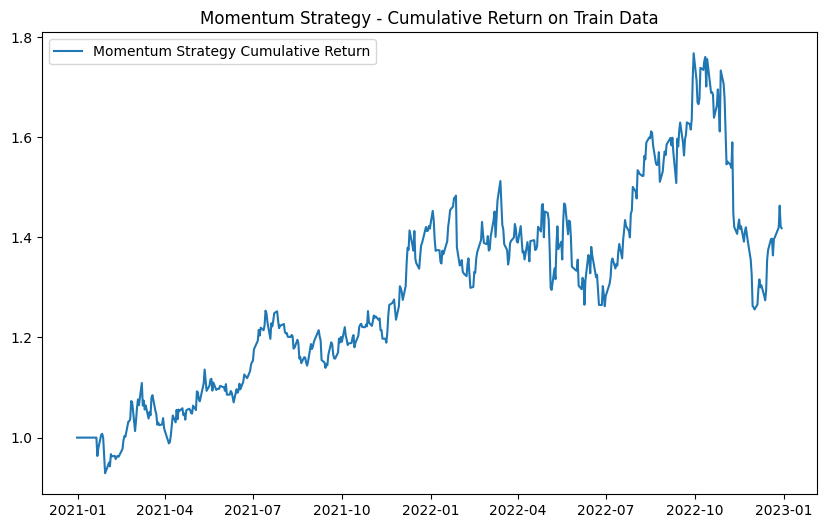

In [78]:
# Apply the RSI and Moving Average strategies on the testing data
test_data_rsi = rsi_strategy(test_data.copy())
test_data_ma = moving_average_strategy(test_data.copy())
test_data_bs = breakout_strategy(test_data.copy())
test_data_ms = momentum_strategy(test_data.copy())

# Backtest the strategies on the testing data
test_data_rsi = backtest_strategy(test_data_rsi)
test_data_ma = backtest_strategy(test_data_ma)
test_data_bs = backtest_strategy(test_data_bs)
test_data_ms = backtest_strategy(test_data_ms)

# Visualize the cumulative return of both strategies on the testing data
plot_cumulative_return(test_data_rsi, 'RSI Strategy')
plot_cumulative_return(test_data_ma, 'Moving Average Strategy')
plot_cumulative_return(test_data_bs, 'Breakout Strategy')
plot_cumulative_return(test_data_ms, 'Momentum Strategy')

In [79]:
def summarize_strategy(data, strategy_name):
    """
    Summarize the performance of a trading strategy.
    """
    initial_value = data['Cumulative Return'].iloc[0]
    final_value = data['Cumulative Return'].iloc[-1]
    total_return = (final_value - initial_value) * 100

    buy_signals = len(data[data['Signal'] == 1])
    sell_signals = len(data[data['Signal'] == -1])

    print(f"\n\n--- {strategy_name} Performance Summary ---")


    print(f"Initial Investment Value: {initial_value:.2f}")
    print(f"Final Investment Value: {final_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Number of Buy Signals: {buy_signals}")
    print(f"Number of Sell Signals: {sell_signals}")

# Summarize performance on test data
print(f"Analysis for {ticker} from {start_date} to {end_date}")
summarize_strategy(test_data_rsi, 'RSI Strategy')
summarize_strategy(test_data_ma, 'Moving Average Strategy')
summarize_strategy(test_data_bs, 'Breakout Strategy')
summarize_strategy(test_data_ms, 'Momentum Strategy')

Analysis for AAPL from 2013-01-01 to 2023-01-01


--- RSI Strategy Performance Summary ---
Initial Investment Value: 1.00
Final Investment Value: 1.04
Total Return: 4.40%
Number of Buy Signals: 49
Number of Sell Signals: 83


--- Moving Average Strategy Performance Summary ---
Initial Investment Value: 1.00
Final Investment Value: 0.89
Total Return: -10.98%
Number of Buy Signals: 161
Number of Sell Signals: 144


--- Breakout Strategy Performance Summary ---
Initial Investment Value: 1.00
Final Investment Value: 0.96
Total Return: -3.50%
Number of Buy Signals: 67
Number of Sell Signals: 58


--- Momentum Strategy Performance Summary ---
Initial Investment Value: 1.00
Final Investment Value: 1.42
Total Return: 41.82%
Number of Buy Signals: 249
Number of Sell Signals: 241
